In [36]:
import rasterio
from rasterio.plot import show
from pyprojroot import here
from osgeo import gdal
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

In [27]:
img = rasterio.open(here("./data/intermediate/brick2019_OGres.tif"))

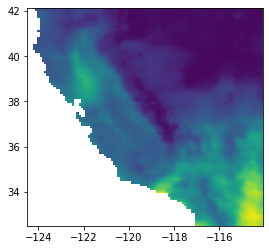

<AxesSubplot:>

In [30]:
show(img)

In [31]:
img.name

'/Users/annaboser/Documents/GitHub/ET_agriculture/data/intermediate/brick2019_OGres.tif'

In [32]:
img.count

365

In [33]:
img.width

103

In [37]:
dataset = gdal.Open(here("./data/intermediate/brick2019_OGres.tif"), gdal.GA_ReadOnly) 
# Note GetRasterBand() takes band no. starting from 1 not 0
band = dataset.GetRasterBand(1)
arr = band.ReadAsArray()
plt.imshow(arr)

RuntimeError: not a string

In [39]:
dataset = gdal.Open(here('./data/intermediate/brick2019_OGres.tif'))

RuntimeError: not a string

In [40]:
here('./data/intermediate/brick2019_OGres.tif')


PosixPath('/Users/annaboser/Documents/GitHub/ET_agriculture/data/intermediate/brick2019_OGres.tif')